In [1]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.test_suite import TestSuite
from checklist.expect import Expect

If you read the [paper](https://homes.cs.washington.edu/~marcotcr/acl20_checklist.pdf), you know that CheckList is more than this package, it's also a process.  
This tutorial is a short version of that process, but you should really read the paper if you haven't :)

# Task and Model: QQP, BERT

For the purpose of this tutorial, we'll use Quora Question Pair as an example, and I'm running a finetuned BERT model in a server.  
The details below are not important, but are necessary for me to run the rest of the notebook. You won't be able to run them, but you can substitute your own model here if you want.

Loading the model and spacy:

In [2]:
from checklist.pred_wrapper import PredictorWrapper
import sys
import spacy
import numpy as np
sys.path.append('/home/marcotcr/work/ml-tests/')
from mltests import model_wrapper
model = model_wrapper.ModelWrapper()
new_pp = PredictorWrapper.wrap_softmax(model.predict_proba)
nlp = spacy.load('en_core_web_sm')


Loading the dataset:

In [3]:
qs = []
labels = []
all_questions = set()
for x in open('/home/marcotcr/datasets/glue/glue_data/QQP/dev.tsv').readlines()[1:]:
    try:
        q1, q2, label = x.strip().split('\t')[3:]
    except:
        print(x)
        continue
    all_questions.add(q1)
    all_questions.add(q2)
    qs.append((q1, q2))
    labels.append(label)
labels = np.array(labels).astype(int)


"	What does the Quran say about homosexuality?	0



Loading dataset preprocessed by spacy:

In [4]:
import pickle
spacy_map =  pickle.load(open('/home/marcotcr/tmp/processed_qqp.pkl', 'rb'))
parsed_qs = [(spacy_map[q[0]], spacy_map[q[1]]) for q in qs]

# Top-Down approach: the CheckList matrix

## Capabilities x Test Types

In tutorial #3, we talked about specific test types.  
In order to guide test ideation, it's useful to think of CheckList as a matrix of Capabilities x Test Types.  
*Capabilities* refers to general-purpose linguistic capabilities, which manifest in one way or another in almost any NLP application.   
We suggest that anyone CheckListing a model go through *at least* the following capabilities, trying to create MFTs, INVs, and DIRs for each if possible.
1. **Vocabulary + POS:** important words or groups of words (by part-of-speech) for the task
2. **Taxonomy**: synonyms, antonyms, word categories, etc
3. **Robustness**: to typos, irrelevant additions, contractions, etc
4. **Named Entity Recognition (NER)**: person names, locations, numbers, etc
5. **Fairness**
6. **Temporal understanding**: understanding order of events and how they impact the task
7. **Negation**
8. **Coreference** 
9. **Semantic Role Labeling (SRL)**: understanding roles such as agent, object, passive/active, etc
10. **Logic**: symmetry, consistency, conjunctions, disjunctions, etc

Notice that we are framing this as very top-down approach: you start with a list of capabilities and try to think of what kinds of tests can be created, based on the three test types. We'll talk about how to incorporate some bottom-up thinking later on.

We won't try to create tests for **all** of these capabilities (but we do have notebooks with tests for all of them in the repo), just one as an example. 
Anyway, let's create a test suite (used to save and aggregate tests):

In [5]:
suite = TestSuite()
editor = Editor()

## Capability: NER

Let's start with the NER capability.  
How do named entities impact duplicate question detection? 


### MFT
It seems that the model should at least be able to distinguish questions about different people as non-duplicates.   
Let's write an MFT where we have two people that have the same last name, but different first names.  
Instead of running the test now, we'll add it to the suite and run all tests later.

In [6]:
t = editor.template((
    'Is {first_name} {last_name} {mask}?',
    'Is {first_name2} {last_name} {mask}?',
    ),
    remove_duplicates=True, 
    nsamples=300)
test = MFT(**t, labels=0, name='same adjectives, different people', capability = 'NER',
          description='Different first name, same adjective and last name')
suite.add(test)
print(t.data[0])
print(t.data[1])

('Is Heather Wilson drunk?', 'Is Jamie Wilson drunk?')
('Is Thomas Garcia Missing?', 'Is Olivia Garcia Missing?')


### INV
If you have two questions with the same named entity, changing the entity on both should not change whether the questions are duplicates or not.  
Let's write an INV for this.

Since we are dealing with pairs of questions, we have to write a wrapper to make sure the same name is changed on both:

In [7]:
def change_name_on_both(qs):
    q1, q2 = qs
    c1 = Perturb.change_names(q1, seed=1, meta=True)
    c2 = Perturb.change_names(q2, seed=1, meta=True)
    if not c1 or not c2:
        return
    # separating out examples and meta. Meta has tuples (a, b), where name 'a' was changed to 'b'
    c1, m1 = c1
    c2, m2 = c2
    # Only include examples where the same name was changed on both questions
    return [(q1, q2) for q1, q2, m1, m2 in zip(c1, c2, m1, m2) if m1 == m2][:10]

In [10]:
t = Perturb.perturb(parsed_qs, change_name_on_both, nsamples=200)
test = INV(**t, name='Change same name in both questions', capability='NER',
          description='')
# test.run(new_pp)
# test.summary(3)
suite.add(test)
print(t.data[0][0])
print(t.data[0][1])
print(t.data[0][2])

('Who do you think will win, Trump or Hillary?', 'Who is going to win, Trump or Hillary?')
('Who do you think will win, Trump or Kayla?', 'Who is going to win, Trump or Kayla?')
('Who do you think will win, Trump or Kimberly?', 'Who is going to win, Trump or Kimberly?')


### DIR
Conversely, if an entity is present on a pair the model predicts as a duplicate and we change it to something else on *only one* of the sentences, the prediction should change to non-duplicate.  
Let's write this as a DIR test:

In [11]:
def change_name_on_one(qs):
    q1, q2 = qs
    c1 = Perturb.change_names(q1, seed=1, meta=True)
    c2 = Perturb.change_names(q2, seed=1, meta=True)
    if not c1 or not c2:
        return
    c1, m1 = c1
    c2, m2 = c2
    ret = []
    ret.extend([(q1_, str(q2)) for q1_, m1_ in zip(c1, m1) if m1_[0] in str(q2)])
    ret.extend([(str(q1), q2_) for q2_, m2_ in zip(c2, m2) if m2_[0] in str(q1)])
    return ret

We'll write an expectation function in two steps.  
First, we want the prediction to be 0.  
Second, we only want to include examples where the original prediction is one. We do this with a slice wrapper:

In [12]:
expect_fn = Expect.eq(0)
expect_fn = Expect.slice_orig(expect_fn, lambda orig, *args: orig == 1)


Let's put it all together into a test:

In [13]:
t = Perturb.perturb(parsed_qs, change_name_on_one, nsamples=200)
name = 'Change name in one of the questions'
desc = 'Take pairs that are originally predicted as duplicates, change name in one of them and expect new prediction to be non-duplicate'
test = DIR(**t, expect=expect_fn, name=name, description=desc, capability='NER')
suite.add(test)
print(t.data[0][0])
print(t.data[0][1])
print(t.data[0][2])

('Who do you think will win, Trump or Hillary?', 'Who is going to win, Trump or Hillary?')
('Who do you think will win, Trump or Kayla?', 'Who is going to win, Trump or Hillary?')
('Who do you think will win, Trump or Kimberly?', 'Who is going to win, Trump or Hillary?')


These examples illustrate how thinking through the matrix can help test ideation. We now turn to a bottom up approach

# Bottom up approach

In this approach, we look at specific examples (from the validation dataset or elsewhere) and try to generalize them into MFTs, INVs or DIRs, placing them into a specific capability.  
Here is an example:

In [14]:
np.random.seed(14)
i = np.random.choice(len(qs))
qs[i]

('Which company should I join as a fresher, TCS or Virtusa?',
 'Is it a good decision to join Tcs as a fresher?')

This is a good example, in which a question asks about a comparison between two options, while the other question asks about a single option.  
While they are not duplicates, it is possible that models would get confused here. I think this test fits into the Vocabulary+POS capability (it's not crucial for us to be completely precise about where a test fits).  
Let's try to create an MFT out of it:

In [15]:
', '.join(editor.suggest('{mask} is a large tech company.')[:40])

'Apple, Google, Facebook, This, Microsoft, Amazon, Uber, It, Intel, Samsung, Netflix, Tesla, Twitter, LinkedIn, Oracle, Target, Snap, Disney, AMD, Bloomberg, Sony, That, Wikipedia, China, Here, Fox, this, HP, FB, YouTube, Reddit, Ford, Pinterest, Harris, MIT, GE, CBS, Dialog, Square, Orange'

In [16]:
companies = ['Apple', 'Google', 'Facebook', 'Microsoft', 'Amazon', 'Uber', 'Intel', 'Samsung', 'Netflix', 'Tesla', 'LinkedIn', 'Oracle', 'Target', 'Snap', 'Disney', 'AMD', 'Sony', 'Reddit', 'Youtube']

In [17]:
', '.join(editor.suggest('Should I join {company} as a {mask}?', company=companies)[:30])

'customer, shareholder, developer, member, contributor, competitor, CEO, volunteer, writer, buyer, contractor, professional, student, director, consumer, manager, result, whole, rookie, client, refugee, sponsor, person, seller, consultant, subscriber, user, beta, startup, citizen'

In [18]:
role = ['developer', 'contributor', 'freshman', 'college grad', 'volunteer', 'writer', 'contractor', 'consultant']

In [19]:
t = editor.template((
       'Which company should I join as a {role}, {company1} or {company2}?',
       'Should I join {company1} as a {role}?',
   ),
    company=companies,
    role=role,
    remove_duplicates=True,
    nsamples=100,
)
print(t.data[0])
print(t.data[1])
print(t.data[2])

('Which company should I join as a contributor, Samsung or Facebook?', 'Should I join Samsung as a contributor?')
('Which company should I join as a volunteer, LinkedIn or Sony?', 'Should I join LinkedIn as a volunteer?')
('Which company should I join as a consultant, Disney or Apple?', 'Should I join Disney as a consultant?')


We've replicated the original example, but we can generalize it a bit to other comparisons:

In [20]:
', '.join([str(x) for x in editor.suggest('Will Google\'s {mask} {mask}?')][:50])

"('efforts', 'succeed'), ('strategy', 'work'), ('dominance', 'continue'), ('efforts', 'work'), ('plan', 'work'), ('strategy', 'working'), ('dominance', 'end'), ('experiment', 'work'), ('attempts', 'succeed'), ('approach', 'work'), ('success', 'continue'), ('tactics', 'work'), ('strategy', 'succeed'), ('experiment', 'succeed'), ('strategy', 'stick'), ('gamble', 'succeed'), ('gamble', 'work'), ('strategy', 'continue'), ('dominance', 'last'), ('strategy', 'worked'), ('dominance', 'sustainable'), ('crackdown', 'work'), ('plans', 'work'), ('efforts', 'continue'), ('decision', 'stick'), ('plan', 'succeed'), ('growth', 'continue'), ('experiments', 'work'), ('decision', 'stand'), ('strategy', 'change'), ('effort', 'succeed'), ('efforts', 'working'), ('attempts', 'work'), ('domination', 'continue'), ('move', 'work'), ('strategies', 'work'), ('lawsuit', 'succeed'), ('efforts', 'successful'), ('methods', 'work'), ('policies', 'change'), ('dominance', 'over'), ('strategy', 'stuck'), ('focus', 'cha

In [21]:
t += editor.template((
       'Which company\'s {fverb[0]} will {fverb[1]} {comp}, {company1} or {company2}?',
       'Will {company1}\'s {fverb[0]} {fverb[1]}?',
   ),
    company=companies,
    comp=['most', 'least', 'sooner', 'later'],
    fverb=[('stock', 'rise'), ('CEO', 'quit'), ('board', 'resign'), ('stock', 'fall'), ('effort', 'succeed'), ('strategy', 'work'), ('plan', 'work'), ('gamble', 'work'), ('focus', 'change'), ('intentions', 'change')],
    nsamples=300,
    remove_duplicates=True,
)
print(t.data[-1])
print(t.data[-2])
print(t.data[-3])

("Which company's effort will succeed most, Youtube or LinkedIn?", "Will Youtube's effort succeed?")
("Which company's plan will work sooner, Disney or Sony?", "Will Disney's plan work?")
("Which company's CEO will quit later, Netflix or Sony?", "Will Netflix's CEO quit?")


In [22]:
test = MFT(**t, labels=0, name='Comparison between two entities is not the same as asking about one', capability = 'Vocabulary',
          description='')
suite.add(test)


# Running the suite, seeing results

In [24]:
suite.run(new_pp)

Running same adjectives, different people
Predicting 299 examples
Running Change same name in both questions
Predicting 2074 examples
Running Change name in one of the questions
Predicting 3837 examples
Running Comparison between two entities is not the same as asking about one
Predicting 380 examples


We can see a (text) summary of the results by calling `suite.summary()`

In [26]:
suite.summary()

Vocabulary

Comparison between two entities is not the same as asking about one
Test cases:      380
Fails (rate):    0 (0.0%)




NER

same adjectives, different people
Test cases:      299
Fails (rate):    22 (7.4%)

Example fails:
1.0 ('Is Joshua Ortiz transgender?', 'Is Joseph Ortiz transgender?')
----
1.0 ('Is Samantha Fisher insane?', 'Is Sara Fisher insane?')
----
0.8 ('Is Joshua Smith crazy?', 'Is Anthony Smith crazy?')
----


Change same name in both questions
Test cases:      200
Fails (rate):    18 (9.0%)

Example fails:
0.7 ('Can Hillary Clinton be charged of perjury for not releasing the entirety of her emails?', "Why hasn't Hillary Clinton been charged with perjury?")
0.0 ('Can Emily Parker be charged of perjury for not releasing the entirety of her emails?', "Why hasn't Emily Parker been charged with perjury?")
0.0 ('Can Jessica Cox be charged of perjury for not releasing the entirety of her emails?', "Why hasn't Jessica Cox been charged with perjury?")

----
0.9 ('Is th

Or if we're using jupyter, we can use a nifty visualization that has all of the tests we created in a matrix:

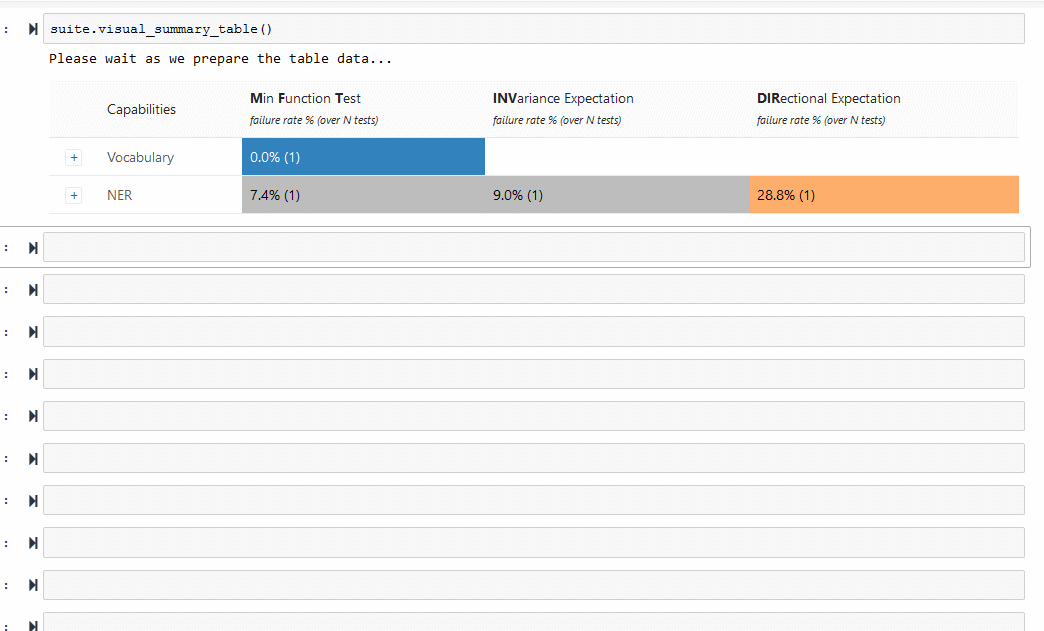

In [28]:
# from IPython.display import HTML, Image
# with open('visual_table_summary.gif','rb') as f:
#     display(Image(data=f.read(), format='png'))
suite.visual_summary_table()

## Bonus: testing Taxonomy

Let's create a few additional tests for the Taxonomy capability

In [29]:
tmp = []
x = editor.suggest('How can I become more {mask}?')
x += editor.suggest('How can I become less {mask}?')
for a in set(x):
    e = editor.synonyms('How can I become {moreless} %s?' % a, a, moreless=['more', 'less'])
    if e:
#         print(a, [b[0][0] for b in e] )
        tmp.append([a] + e)
#         opps.append((a, e[0][0][0]))
print(', '.join([str(tuple(x)) for x in tmp][:50]))

('aware', 'mindful'), ('resilient', 'live'), ('charitable', 'sympathetic', 'benevolent'), ('evil', 'vicious'), ('nervous', 'anxious'), ('competitive', 'militant'), ('independent', 'autonomous'), ('grateful', 'thankful'), ('shy', 'timid', 'unsure'), ('demanding', 'exact'), ('depressed', 'blue'), ('organized', 'organised', 'direct'), ('rigid', 'strict', 'fixed', 'stiff'), ('effective', 'efficient'), ('important', 'authoritative', 'significant'), ('stressed', 'stress'), ('sensitive', 'sensible'), ('inspired', 'divine'), ('controlling', 'moderate', 'control'), ('clear', 'open', 'clean', 'light', 'clearly'), ('progressive', 'liberal', 'imperfect'), ('bad', 'sorry', 'tough', 'risky', 'spoiled', 'defective'), ('hateful', 'mean'), ('conservative', 'cautious'), ('hopeful', 'promising', 'bright'), ('kind', 'tolerant'), ('strict', 'rigid', 'stern'), ('desperate', 'heroic'), ('emotional', 'excited'), ('upset', 'worried', 'broken', 'confused', 'distressed', 'disturbed'), ('alienated', 'alien', 'est

Out of all of those, let's pick a few:

In [30]:
synonyms = [ ('spiritual', 'religious'), ('angry', 'furious'), ('organized', 'organised'),
            ('vocal', 'outspoken'), ('grateful', 'thankful'), ('intelligent', 'smart'),
            ('humble', 'modest'), ('courageous', 'brave'), ('happy', 'joyful'), ('scared', 'frightened'),
           ]

With these, we can create a simple MFT, where we expect the model to recognize these synonyms.  


In [31]:
t = editor.template(
    (
    'How can I become {moreless} {x[0]}?',
    'How can I become {moreless} {x[1]}?',
    ),
    x=synonyms,
    moreless=['more', 'less'],
    remove_duplicates=True, 
    nsamples=200)
name = 'How can I become more {synonym}?' 
desc = 'different (simple) templates where words are replaced with their synonyms'
test = MFT(**t, labels=1, name=name, capability = 'Taxonomy',
          description=desc)
suite.add(test)

Let's do the same with antonyms:

In [32]:
opps = []
x = editor.suggest('How can I become more {mask}?')
x += editor.suggest('How can I become less {mask}?')
for a in set(x):
    e = editor.antonyms('How can I become {moreless} %s?' % a, a, moreless=['more', 'less'])
    if e:
#         print(a, [b[0][0] for b in e] )
        opps.append([a] + e)
#         opps.append((a, e[0][0][0]))
print(','.join([str(tuple(x)) for x in opps]))

('defensive', 'offensive'),('shy', 'confident'),('optimistic', 'pessimistic'),('progressive', 'conservative'),('bad', 'good'),('conservative', 'liberal', 'progressive'),('hopeful', 'hopeless'),('impatient', 'patient'),('emotional', 'intellectual'),('capitalist', 'socialist'),('individual', 'common'),('smart', 'stupid'),('fat', 'lean', 'thin'),('dependent', 'independent'),('powerless', 'powerful'),('organic', 'functional'),('passive', 'active'),('pessimistic', 'optimistic'),('specific', 'general'),('humble', 'proud'),('unhappy', 'happy'),('hungry', 'thirsty'),('insecure', 'secure'),('conspicuous', 'invisible'),('rude', 'polite', 'civil'),('irresponsible', 'responsible'),('courageous', 'fearful'),('religious', 'secular'),('positive', 'negative', 'neutral'),('visible', 'invisible'),('cautious', 'brave'),('negative', 'positive'),('stupid', 'smart', 'intelligent'),('active', 'passive')


In [33]:
antonyms = [('progressive', 'conservative'),('religious', 'secular'),('positive', 'negative'),('defensive', 'offensive'),('rude',  'polite'),('optimistic', 'pessimistic'),('stupid', 'smart'),('negative', 'positive'),('unhappy', 'happy'),('active', 'passive'),('impatient', 'patient'),('powerless', 'powerful'),('visible', 'invisible'),('fat', 'thin'),('bad', 'good'),('cautious', 'brave'), ('hopeful', 'hopeless'),('insecure', 'secure'),('humble', 'proud'),('passive', 'active'),('dependent', 'independent'),('pessimistic', 'optimistic'),('irresponsible', 'responsible'),('courageous', 'fearful')]

In [34]:
t = editor.template([(
    'How can I become more {x[0]}?',
    'How can I become less {x[1]}?',
    ),
    (
    'How can I become less {x[0]}?',
    'How can I become more {x[1]}?',
    )],
    unroll=True,
    x=antonyms,
    remove_duplicates=True, 
    nsamples=300)
name = 'How can I become more X = How can I become less antonym(X)' 
desc = ''
test = MFT(**t, labels=1, name=name, capability = 'Taxonomy',
          description=desc)
suite.add(test)

It would be easy to turn the synonym one into an INV as well (we do this in another notebook), but let's end here after we run the suite again and see new results.

In [35]:
suite.run(new_pp, overwrite=True)

Running same adjectives, different people
Predicting 299 examples
Running Change same name in both questions
Predicting 2074 examples
Running Change name in one of the questions
Predicting 3837 examples
Running Comparison between two entities is not the same as asking about one
Predicting 380 examples
Running How can I become more {synonym}?
Predicting 200 examples
Running How can I become more X = How can I become less antonym(X)
Predicting 600 examples


In [36]:
suite.summary()

Vocabulary

Comparison between two entities is not the same as asking about one
Test cases:      380
Fails (rate):    0 (0.0%)




Taxonomy

How can I become more {synonym}?
Test cases:      200
Fails (rate):    37 (18.5%)

Example fails:
0.0 ('How can I become less vocal?', 'How can I become less outspoken?')
----
0.3 ('How can I become more spiritual?', 'How can I become more religious?')
----
0.3 ('How can I become more spiritual?', 'How can I become more religious?')
----


How can I become more X = How can I become less antonym(X)
Test cases:      600
Fails (rate):    405 (67.5%)

Example fails:
0.0 ('How can I become more stupid?', 'How can I become less smart?')
----
0.0 ('How can I become more active?', 'How can I become less passive?')
----
0.0 ('How can I become more hopeful?', 'How can I become less hopeless?')
----




NER

same adjectives, different people
Test cases:      299
Fails (rate):    22 (7.4%)

Example fails:
0.8 ('Is Nathan Wilson arrested?', 'Is Benjamin Wilson

In [128]:
suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'How can I become mor…